In [103]:
## start by importing any relevant pkgs

import astropy.constants as c 
import astropy.units as u 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import glob
from astropy.io import fits
import smplotlib
from sklearn.metrics import mean_squared_error
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm


## assign relevant directories

# question 2 directories
data_dir_q2 = 'question-2/data'
fig_dir_q2 = 'question-2/figures'

# question 3 directories
data_dir_q3 = 'question-3/data'
fig_dir_q3 = 'question-3/figures'

# ASTR4004 Assignment 3 Question 2

## 2.1 Task

A colleague is interested in the open cluster Messier 67 (RA = 132.825 deg, Dec = 11.8 deg) and is considering an observation proposal using 2dF fibre positioner and HERMES spectrograph (effective for Gaia G band magnitudes $< 14$). They need to know if there are enough bright stars in this region for observation. Your task is to assist by querying data from Gaia DR3 and performing some basic analysis

### Question 2.1.1

Download all stars within 1 degree of the centre of Messier 67 that are brighter than $G = 14$ in Gaia DR3 (the table is called $\verb|gaiadr.gaia_source|$) and include a crossmatch these stars with the 2MASS catalog and report your ADQL test (use the """$\verb|query|$"" notation). 

In [204]:
from astroquery.gaia import Gaia

# define adql query
query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.bp_rp, gaia.phot_g_mean_mag, tmass.*, 
DISTANCE(135.825, 11.8, gaia.ra, gaia.dec) AS ang_sep
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch
ON gaia.source_id = xmatch.source_id
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE DISTANCE(135.825, 11.8, gaia.ra, gaia.dec) < 1.0
AND gaia.phot_g_mean_mag < 14.0
"""

# initiate the job
job = Gaia.launch_job_async(query=query, upload_table_name="t1")
gaiadr3_match = job.get_results()

print(gaiadr3_match)

INFO: Query finished. [astroquery.utils.tap.core]
    SOURCE_ID              ra         ...    j_date         ang_sep      
                          deg         ...      d                         
------------------ ------------------ ... ------------ ------------------
604540565585697920  136.1328869221082 ...  2451636.714  0.723495795935788
604540634305169280 136.19008486421455 ... 2451636.7152  0.739662833276878
604541562018113920 136.08186800138913 ...  2451636.714 0.7372242177447691
604542386651848448 135.97124664992901 ... 2451636.7055 0.6507985814234806
604543005127132416  136.0379805013731 ... 2451636.7056 0.7103126836416549
604543383084262528 135.92373524073562 ... 2451636.7043 0.6697191240746342
604543657962169984 135.89872645824914 ... 2451636.7043 0.6804158799484505
604545925704787328 135.97794803333835 ... 2451636.7056 0.7659021800453144
604546265006627072  136.0850551741846 ... 2451636.7139 0.8273220398933776
604547295798780032  136.2683746145596 ... 2451636.7153 0.86142

### Question 2.1.2 Determine how many stars ar returned from the initial query.

In [205]:
print(f"The number of stars returned from the initial query = {len(gaiadr3_match['SOURCE_ID'])}.")

The number of stars returned from the initial query = 556.


### Question 2.1.3 Identify any stars with bad 2MASS photometry, where $\verb|ph_qual|$ is not `AAA.'

In [206]:
bad_2mass = []

for i in range(len(gaiadr3_match['SOURCE_ID'])):
    row = gaiadr3_match[i]
    if row['ph_qual'] != 'AAA':
        bad_2mass.append(row)

print(f"The number of stars with bad 2MASS photometry = {len(bad_2mass)}.")

The number of stars with bad 2MASS photometry = 5.


### Question 2.1.4 Identify any stars with negative (or non-positive) parallaxes in the GAIA data

In [207]:
bad_parallax = []

for i in range(len(gaiadr3_match['SOURCE_ID'])):
    row = gaiadr3_match[i]
    if row['parallax'] < 0:
        bad_parallax.append(row)

print(f"The number of stars with bad parallaxes = {len(bad_parallax)}.")

The number of stars with bad parallaxes = 0.


### Question 2.1.5 Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes). After applyng the cuts, determine how many stars remain.

In [208]:
# create a bad 2mass photometry and/or parallax mask
bad_mask = (gaiadr3_match['ph_qual'] != 'AAA') | (gaiadr3_match['parallax'] < 0)

# apply quality cuts
gaiadr3_match_good = gaiadr3_match[~bad_mask]

print(f"After applying the two quality cuts {len(gaiadr3_match_good)} stars remain due to {len(gaiadr3_match) - len(gaiadr3_match_good)} being removed.")

After applying the two quality cuts 551 stars remain due to 5 being removed.


### Question 2.1.6 Using the remaining stars, generate a figure with two panels (1 point per panel):
- (a) A colour-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.
- (b) A 2MASS J-Bs vs. apparent K magnitude diagram.

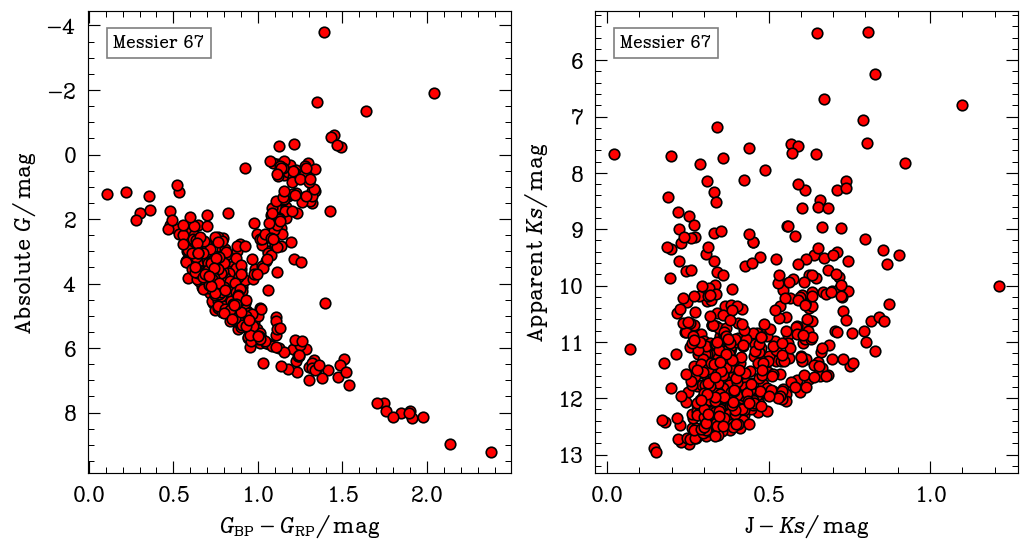

In [231]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.scatter(gaiadr3_match_good['bp_rp'], gaiadr3_match_good['phot_g_mean_mag']  + 5 * np.log10(gaiadr3_match_good['parallax']/100.), s=40, color='red', edgecolor='black')
ax1.invert_yaxis()

ax1.set_xlabel('$G_\mathrm{BP}-G_\mathrm{RP}/\mathrm{\, mag}$')
ax1.set_ylabel('Absolute $G/\mathrm{\,mag}$')

ax1.text(0.06, 0.95, 'Messier 67', transform=ax1.transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


ax2.scatter(gaiadr3_match_good['j_m'] - gaiadr3_match_good['ks_m'], gaiadr3_match_good['ks_m'], s=40, color='red', edgecolor='black')
ax2.invert_yaxis()

ax2.set_xlabel('$\mathrm{J}-{Ks}/\mathrm{\, mag}$')
ax2.set_ylabel('Apparent $Ks/\mathrm{\,mag}$')

ax2.text(0.06, 0.95, 'Messier 67', transform=ax2.transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.savefig(os.path.join(fig_dir_q2, 'cmds_M67.png'), dpi=200)

### Question 2.1.7 Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

Based on the plotted figure, particularly the left panel, there are evidently enough bright stars that HERMES would be sensitive to ($G < 14$) to define the cluster Messier 67. This would certaintly warrant putting forward a proposal to use the 2dF fibre position and HERMES spectrograph based only on the brightness criterion. It is also visible to the southern hemisphere at certain times of the year so it is also feasible on that criteria.


# ASTR4004 Assignment 3 Question 3

## 3.1 Background

The radial metallicity relation is a function that descirbes the change of metallicity - here the gas phase metallicty $\mathrm{A(O)} = \log_{10}(N_\mathrm{O}/N_\mathrm{H}) + 12$ - along the galacocentric radius $R_\mathrm{Gal}$. Understanding the radial metallicty gradient in galaxies provides critical insights into their formation and evolutionary processes, such as inside-out formation, gas accretion, outflows, and radial migration. A lot of work has been done through obsevational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simualtions and a few simulations (e.g. Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand the radial metallicity gradient!

Your colleage has just finished an exciting cosmological simulation that traces the gas phase metallicity for a Milky Way analogue, that is, a sprial galaxy. They have limited the simulation data to the positions $(\mathrm{x, y, z})$ of the innermost gas particles ($R_\mathrm{Gal} < 25\,\mathrm{kpc}$) and their gas phase metallicity $\mathrm{A(O)}$ and uploaded them as a FITS file for you here: https://github.com/svenbuder/astr4004_2024_week7/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits.

## 3.2 Task

Downlaod the file from the link above into $\verb|data/|$. Load the file with $\verb|python|$ and then perform the following tasks to create figures that are saved in $\verb|figures/|$: 

### 3.2 Intro - Data Handling

In [3]:
## read in the FITS data file
nihao_sim_fits = fits.open(glob.glob(os.path.join(data_dir_q3, f'*.fits'))[0])
nihao_sim_data = nihao_sim_fits[1].data # each row n has 4 elements in the format (x, y, z, A(O))

## store data in relevant lists
xlist = []
ylist = []
zlist = []
gas_met_list = []

for row in range(len(nihao_sim_data)):
    xlist.append(nihao_sim_data[row][0])
    ylist.append(nihao_sim_data[row][1])
    zlist.append(nihao_sim_data[row][2])
    gas_met_list.append(nihao_sim_data[row][3])

# convert these lists to arrays for easy computation
xarr = np.array(xlist)
yarr = np.array(ylist)
zarr = np.array(zlist)
gas_met_arr= np.array(gas_met_list)

### Question 3.2.1 

Plot a 2-panel figure:
 - (a) Logarithmic density plot of $R_\mathrm{Gal}$ vs. $\mathrm{A(O)}$, with a linear fit and legend.
 - (b) Residuals of the fit, $R_\mathrm{Gal}$ vs. $\mathrm{\Delta A(O)}$. 


### Question 3.2.2 

Use a $\verb|python|$ fitting tool to fit a linear function to the data, reporting the intercept and slope with uncertainties. Include an hyperparameters used.

Linear fit parameters: slope = -0.03420 ± 0.00001, intercept = 9.12784 ± 0.00023


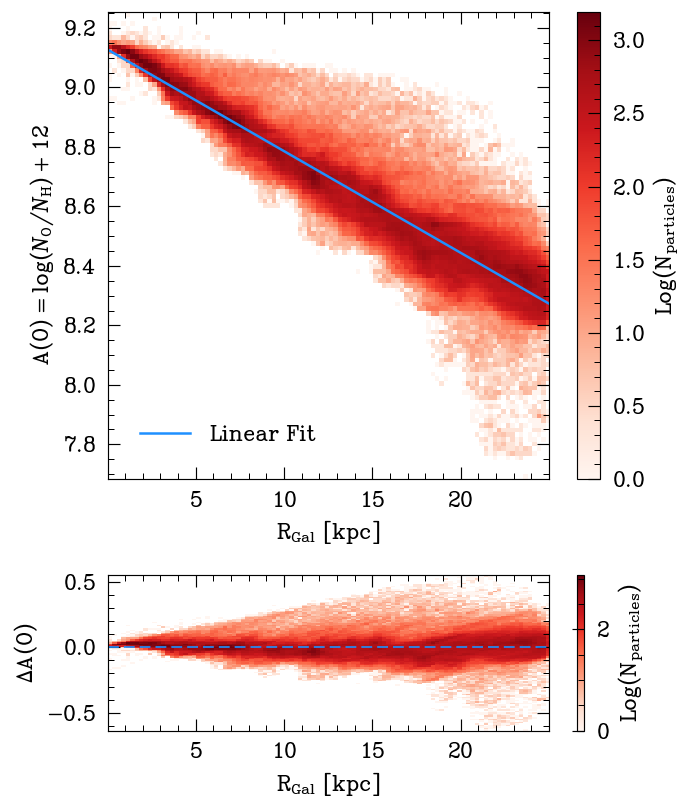

In [4]:
" ---------------- Q3.2.1 PLOTTING THE DATA ---------------- "

# compute Rgal
R_gal = np.sqrt(xarr**2 + yarr**2) # define the radius in cylindrical coordinates 

## make the plot for 3.2.1
fig = plt.figure(figsize=(6, 7))
gs = GridSpec(2, 1, height_ratios=[3, 1])  

##  create plot (a)
ax1 = fig.add_subplot(gs[0])

# histogram w/ logarithmic densities
h1, xedges, yedges = np.histogram2d(R_gal, gas_met_arr, bins=100)
h1_log = np.log10(h1) 

# plot the logarithmic densities using an imshow
im1 = ax1.imshow(h1_log.T, origin='lower', aspect='auto', 
                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Reds')

# add a colour bar
cbar1 = plt.colorbar(im1, ax=ax1, label='Log($\mathrm{N_{particles}})$')

## axes config for ax1
ax1.set_xlabel('$\mathrm{R_{Gal}}$ [kpc]')
ax1.set_ylabel('$\mathrm{A(O)} = \log(N_\mathrm{O}/N_\mathrm{H}) + 12$')


" ---------------- Q3.2.2 FITTING A LINE TO THE DATA ---------------- "

### 3.2.2 fit a line to the data
mask = np.isfinite(R_gal) & np.isfinite(gas_met_arr)  # mask any nan or inf
coeffs, cov = np.polyfit(R_gal[mask], gas_met_arr[mask], 1, cov=True)  # deg 1 for linear

# get the intercept and slope fo the fit
slope = coeffs[0]
intercept = coeffs[1]

# get the uncertainties on the fit (given by the diagonals of the cov array)
slope_err = np.sqrt(cov[0,0])
intercept_err = np.sqrt(cov[1,1])

# print the values of the fit
print(f'Linear fit parameters: slope = {slope:.5f} ± {slope_err:.5f}, intercept = {intercept:.5f} ± {intercept_err:.5f}')

# get the line and plot it
fit_line = np.polyval(coeffs, np.sort(R_gal[mask]))
ax1.plot(np.sort(R_gal[mask]), fit_line, color='dodgerblue', linestyle='solid', linewidth=1.5, label='Linear Fit')

ax1.legend(loc = 'lower left')

# compute resid
residuals = gas_met_arr[mask] - np.polyval(coeffs, R_gal[mask])

# create smaller residual plot below main plot
ax2 = fig.add_subplot(gs[1])

# histogram with log densities
h2, xedges2, yedges2 = np.histogram2d(R_gal[mask], residuals, bins=100)
h2_log = np.log10(h2)  

# plot resid using imshow
im2 = ax2.imshow(h2_log.T, origin='lower', aspect='auto', 
                 extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]], cmap='Reds')

# plot a horizontal line at 0 
ax2.axhline(0, color = 'dodgerblue', linewidth=1,  linestyle='dashed')

# add color bar
cbar2 = plt.colorbar(im2, ax=ax2, label='Log($\mathrm{N_{particles}})$')

## axes config for ax2
ax2.set_xlabel('$\mathrm{R_{Gal}}$ [kpc]')
ax2.set_ylabel('$\mathrm{\Delta A(O)}$')


plt.tight_layout()

# save the figure to the relevant directory
plt.savefig(os.path.join(fig_dir_q3, 'q3.2.1_log_density_plot.pdf'))

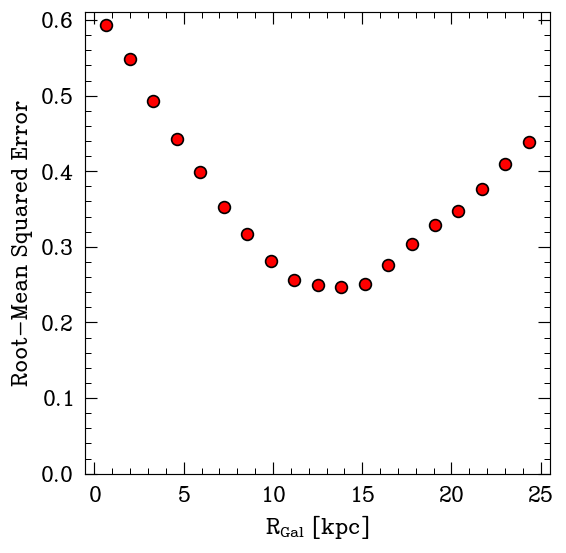

In [5]:
" ----------- Q3.2.3 ------------- "

## we can approach the problem by considering the root mean square in bins of Rgal

# define bins for rmse calc
# bins_rmse = [0, 5, 10 ,15, 20, 25]
bins_rmse = np.linspace(0, np.max(R_gal), 20)

# get the bin centers for plotting
bin_centers = []

for i in range(len(bins_rmse)-1):
    bin_center = ((bins_rmse[i] + bins_rmse[i+1])/2)
    bin_centers.append(bin_center)

rmse_list = [] 

# iterate over bins and calculate root mean square error (rmse) in each bin
for i in range(len(bins_rmse)-1):
    bin_mask = ((R_gal[mask] >= bins_rmse[i]) & (R_gal[mask] < bins_rmse[i+1])) # create a mask such that you only consider the binned region
    if np.any(bin_mask): 
        bin_rmse = np.sqrt(mean_squared_error(gas_met_arr[mask][bin_mask], fit_line[bin_mask]))
        rmse_list.append(bin_rmse)


## plot the RMSE as a fucntion of bins
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(bin_centers, rmse_list, s=50, color='red', edgecolors='black')

# axes config
ax.set_xlabel('$\mathrm{R_{Gal}}$ [kpc]')
ax.set_ylabel('Root-Mean Squared Error')

ax.set_ylim(0)

plt.savefig(os.path.join(fig_dir_q3, 'q323_rmse.pdf'))

Evidently, the linear fit is most poor at the inner part of the galaxy within 10 kpc and in the outer galaxy above 15 kpc while the best fit region is between 10-15 kpc. Overall though, the fit is generally sound.

### Question 3.2.4

Plot a 3-panel figure for the $x \mathrm{\,vs.\,} y$ plane using the same bins and sensible colormaps:
- (a) 2D-histogram of the median simulated $\mathrm{A(O)}$ 
- (b) 2D-histogram of the median fitted $\mathrm{A(O)}$
- (c) 2D-histogram of the median residuals $\mathrm{\Delta A(O)}$

In [101]:
from scipy.stats import binned_statistic_2d # import binned_statistic_2d to calculate the median in each bin

# set the number of bins
nbin = 80

# get the x,y bin edges
bins_x = np.linspace(np.min(xarr), np.max(xarr), nbin)
bins_y = np.linspace(np.min(yarr), np.max(yarr), nbin)

# get the Rgal bin edges
bins_Rgal = np.linspace(np.min(R_gal), np.max(R_gal), len(fit_line))

# calculate the median simulated A(O)
median_sim_AO = binned_statistic_2d(xarr, yarr, gas_met_arr, statistic='median', bins=[bins_x, bins_y])[0]

# project the linear fit 
Rgal_idx = np.digitize(R_gal, bins_Rgal) - 1  # find where the values of R_gal line up with the Rgal bins
Rgal_idx = np.clip(Rgal_idx, 0, len(fit_line) - 1)  # ensure that the range of Rgal_idx does not exceed the length of the linear fit

# map the linear fit of AO to Rgal
projected_fit_AO = fit_line[Rgal_idx]  

# calculate the median fitted A(O)
median_fit_AO = binned_statistic_2d(xarr, yarr, projected_fit_AO, statistic='median', bins=[bins_x, bins_y])[0]

# calculate the median residuals
median_residuals = median_sim_AO - median_fit_AO

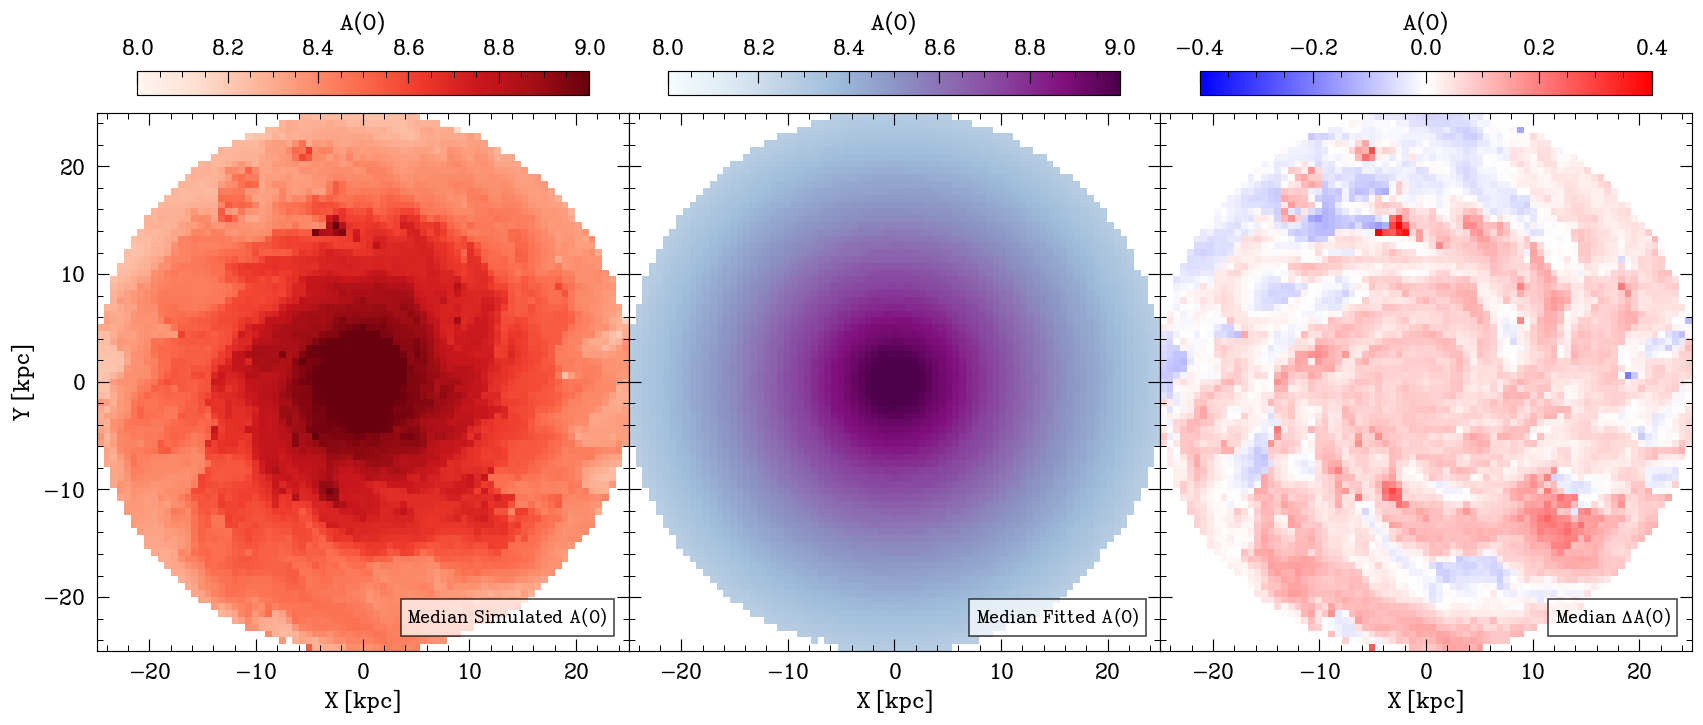

In [102]:

# create a 3 panel
fig, axs = plt.subplots(1,3, figsize=(14, 5), sharey=True)

plt.subplots_adjust(wspace=-1)

## (a) median simualted A(O)
im1 = axs[0].imshow(median_sim_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='Reds', vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[0].text(0.96, 0.04, 'Median Simulated $\mathrm{A(O)}$', transform=axs[0].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[0].set_xlabel('X [kpc]')
axs[0].set_ylabel('Y [kpc]')

# add a colour bar above the plot
cax1 = fig.add_axes([0.0745, 1.03, 0.269, 0.04]) 
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('A(O)', labelpad=-50)  
cbar1.ax.xaxis.set_label_position('bottom')  

cbar1.ax.xaxis.set_ticks_position('top') 
cbar1.ax.xaxis.set_tick_params(labeltop=True)  


## (b) median simualted A(O)
im2 = axs[1].imshow(median_fit_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='BuPu',  vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[1].text(0.96, 0.04, 'Median Fitted $\mathrm{A(O)}$', transform=axs[1].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[1].set_xlabel('X [kpc]')


# add a colour bar above the plot
cax2 = fig.add_axes([0.08 +  0.3105, 1.03, 0.269, 0.04])  
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('A(O)', labelpad=-50)  
cbar2.ax.xaxis.set_label_position('bottom')  

cbar2.ax.xaxis.set_ticks_position('top')  
cbar2.ax.xaxis.set_tick_params(labeltop=True)  


# (c) 2D-histogram of the median residuals ∆A(O)
im3 = axs[2].imshow(median_residuals, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], 
                    cmap='bwr', vmin=-0.4, vmax=0.4) # set the vmin and vmax so the residual colour map diverges from 0.0

axs[2].text(0.96, 0.04, 'Median $\Delta\mathrm{A(O)}$', transform=axs[2].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[2].set_xlabel('X [kpc]')

# add a colour bar above the plot
cax3 = fig.add_axes([0.080 +  0.627, 1.03, 0.269, 0.04])  
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('A(O)', labelpad=-50)  
cbar3.ax.xaxis.set_label_position('bottom')  
cbar3.ax.xaxis.set_ticks_position('top')  
cbar3.ax.xaxis.set_tick_params(labeltop=True)  


plt.tight_layout(pad=0)

plt.savefig(os.path.join(fig_dir_q3,f'q324_3_panel_2d_hist.pdf'), dpi=500)

### Question 3.2.5 

Describe your choice of 2d bins. Discuss what details would be missed with few bins or problems encountered with more bins.

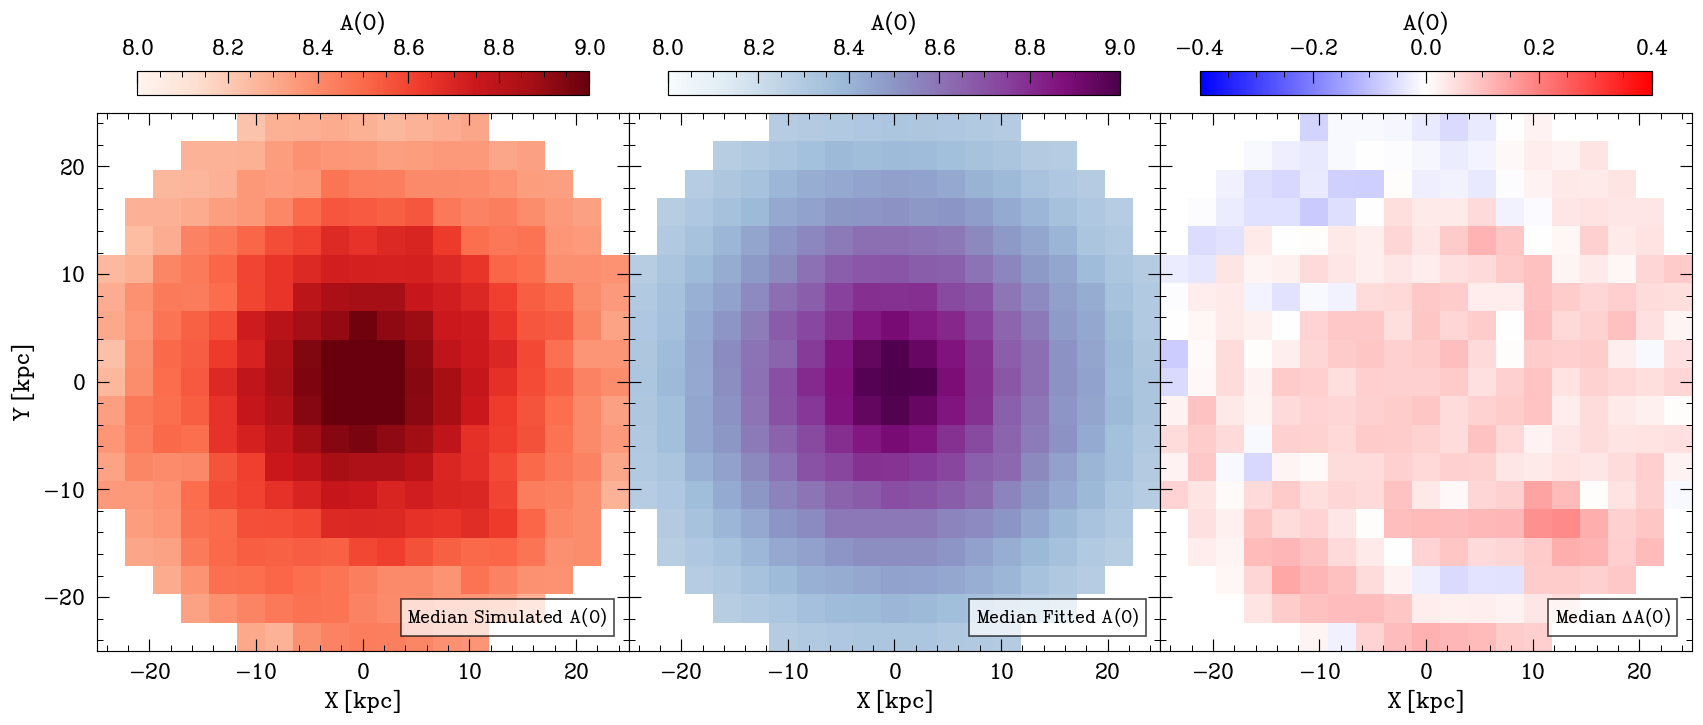

In [98]:
## let's investigate what would happen in the case of too little or too many bins

# set the number of bins (too little)
nbin = 20

# get the x,y bin edges
bins_x = np.linspace(np.min(xarr), np.max(xarr), nbin)
bins_y = np.linspace(np.min(yarr), np.max(yarr), nbin)

# calculate the median simulated A(O)
median_sim_AO = binned_statistic_2d(xarr, yarr, gas_met_arr, statistic='median', bins=[bins_x, bins_y])[0]

# calculate the median fitted A(O)
median_fit_AO = binned_statistic_2d(xarr, yarr, projected_fit_AO, statistic='median', bins=[bins_x, bins_y])[0]

# calculate the median residuals
median_residuals = median_sim_AO - median_fit_AO

# create a 3 panel
fig, axs = plt.subplots(1,3, figsize=(14, 5), sharey=True)

plt.subplots_adjust(wspace=-1)

## (a) median simualted A(O)
im1 = axs[0].imshow(median_sim_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='Reds', vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[0].text(0.96, 0.04, 'Median Simulated $\mathrm{A(O)}$', transform=axs[0].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[0].set_xlabel('X [kpc]')
axs[0].set_ylabel('Y [kpc]')

# add a colour bar above the plot
cax1 = fig.add_axes([0.0745, 1.03, 0.269, 0.04]) 
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('A(O)', labelpad=-50)  
cbar1.ax.xaxis.set_label_position('bottom')  

cbar1.ax.xaxis.set_ticks_position('top') 
cbar1.ax.xaxis.set_tick_params(labeltop=True)  


## (b) median simualted A(O)
im2 = axs[1].imshow(median_fit_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='BuPu',  vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[1].text(0.96, 0.04, 'Median Fitted $\mathrm{A(O)}$', transform=axs[1].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[1].set_xlabel('X [kpc]')


# add a colour bar above the plot
cax2 = fig.add_axes([0.08 +  0.3105, 1.03, 0.269, 0.04])  
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('A(O)', labelpad=-50)  
cbar2.ax.xaxis.set_label_position('bottom')  

cbar2.ax.xaxis.set_ticks_position('top')  
cbar2.ax.xaxis.set_tick_params(labeltop=True)  


# (c) 2D-histogram of the median residuals ∆A(O)
im3 = axs[2].imshow(median_residuals, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], 
                    cmap='bwr', vmin=-0.4, vmax=0.4) # set the vmin and vmax so the residual colour map diverges from 0.0

axs[2].text(0.96, 0.04, 'Median $\Delta\mathrm{A(O)}$', transform=axs[2].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[2].set_xlabel('X [kpc]')

# add a colour bar above the plot
cax3 = fig.add_axes([0.080 +  0.627, 1.03, 0.269, 0.04])  
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('A(O)', labelpad=-50)  
cbar3.ax.xaxis.set_label_position('bottom')  
cbar3.ax.xaxis.set_ticks_position('top')  
cbar3.ax.xaxis.set_tick_params(labeltop=True)  


plt.tight_layout(pad=0)

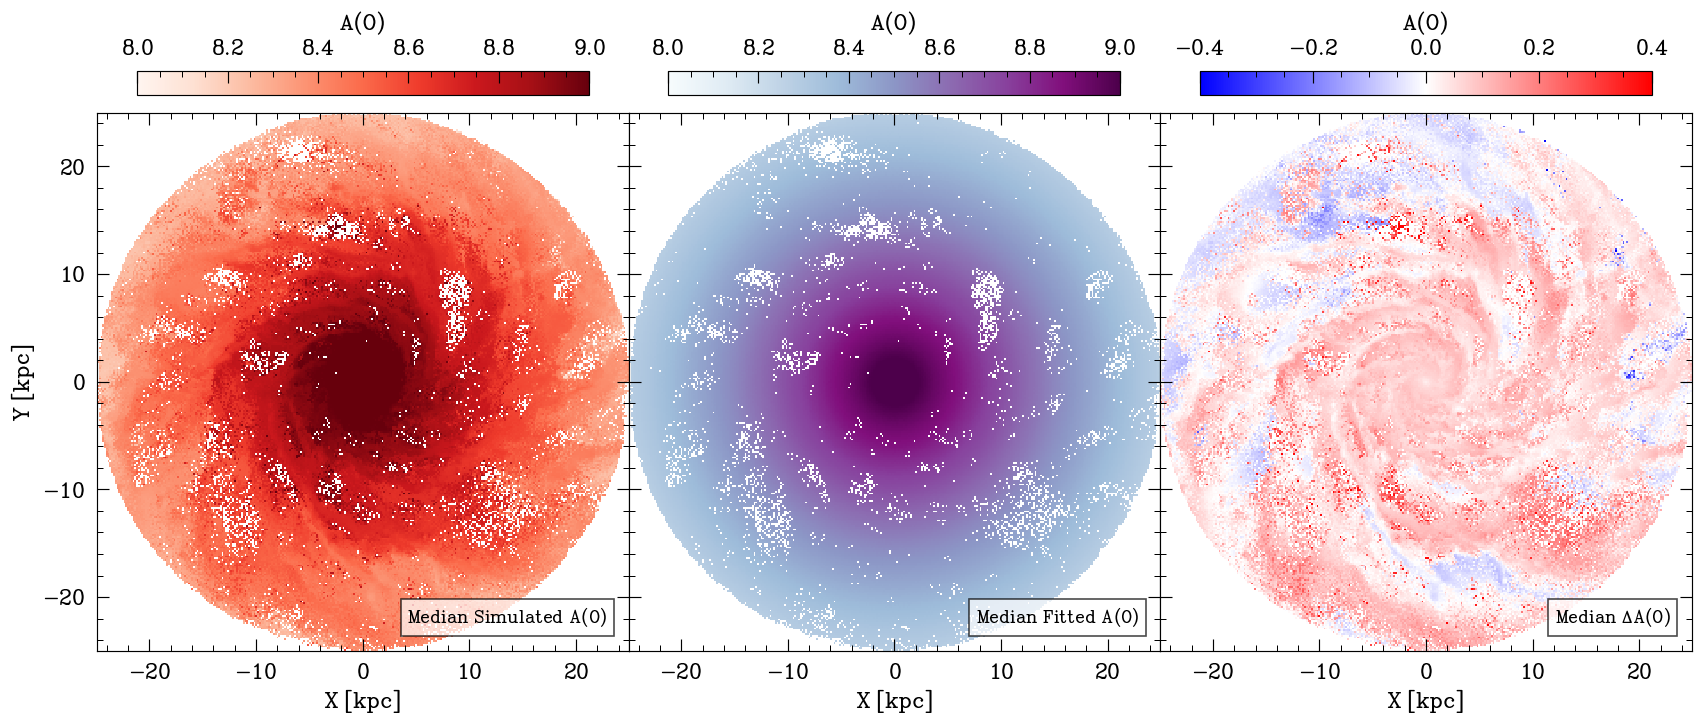

In [99]:
# now for too many bins

# set the number of bins (too little)
nbin = 300

# get the x,y bin edges
bins_x = np.linspace(np.min(xarr), np.max(xarr), nbin)
bins_y = np.linspace(np.min(yarr), np.max(yarr), nbin)

# calculate the median simulated A(O)
median_sim_AO = binned_statistic_2d(xarr, yarr, gas_met_arr, statistic='median', bins=[bins_x, bins_y])[0]

# calculate the median fitted A(O)
median_fit_AO = binned_statistic_2d(xarr, yarr, projected_fit_AO, statistic='median', bins=[bins_x, bins_y])[0]

# calculate the median residuals
median_residuals = median_sim_AO - median_fit_AO

# create a 3 panel
fig, axs = plt.subplots(1,3, figsize=(14, 5), sharey=True)

plt.subplots_adjust(wspace=-1)

## (a) median simualted A(O)
im1 = axs[0].imshow(median_sim_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='Reds', vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[0].text(0.96, 0.04, 'Median Simulated $\mathrm{A(O)}$', transform=axs[0].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[0].set_xlabel('X [kpc]')
axs[0].set_ylabel('Y [kpc]')

# add a colour bar above the plot
cax1 = fig.add_axes([0.0745, 1.03, 0.269, 0.04]) 
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('A(O)', labelpad=-50)  
cbar1.ax.xaxis.set_label_position('bottom')  

cbar1.ax.xaxis.set_ticks_position('top') 
cbar1.ax.xaxis.set_tick_params(labeltop=True)  


## (b) median simualted A(O)
im2 = axs[1].imshow(median_fit_AO, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], cmap='BuPu',  vmin=8, vmax=9)

# add text to describe what the plot is showing
axs[1].text(0.96, 0.04, 'Median Fitted $\mathrm{A(O)}$', transform=axs[1].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[1].set_xlabel('X [kpc]')


# add a colour bar above the plot
cax2 = fig.add_axes([0.08 +  0.3105, 1.03, 0.269, 0.04])  
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('A(O)', labelpad=-50)  
cbar2.ax.xaxis.set_label_position('bottom')  

cbar2.ax.xaxis.set_ticks_position('top')  
cbar2.ax.xaxis.set_tick_params(labeltop=True)  


# (c) 2D-histogram of the median residuals ∆A(O)
im3 = axs[2].imshow(median_residuals, origin='lower', aspect='auto', extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]], 
                    cmap='bwr', vmin=-0.4, vmax=0.4) # set the vmin and vmax so the residual colour map diverges from 0.0

axs[2].text(0.96, 0.04, 'Median $\Delta\mathrm{A(O)}$', transform=axs[2].transAxes, 
            fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7))

axs[2].set_xlabel('X [kpc]')

# add a colour bar above the plot
cax3 = fig.add_axes([0.080 +  0.627, 1.03, 0.269, 0.04])  
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('A(O)', labelpad=-50)  
cbar3.ax.xaxis.set_label_position('bottom')  
cbar3.ax.xaxis.set_ticks_position('top')  
cbar3.ax.xaxis.set_tick_params(labeltop=True)  


plt.tight_layout(pad=0)

Clearly there are issues when too little or too many bins are used. In the case where too little bins are used ($\sim 20$), it is clear that the structural features of the galaxy are lost when the bins are undersampled smoothing out any potentially interesting properties of the galaxy. When using too many bins ($\sim 200$) however, while this also increases the computational cost (minimally in this case) it also leads to oversampling introducing a new issue: many of the histogram bins contain little to no data points. As a consequence, the plots appear patchy with undefined values also losing potentially interesting structure.

### Question 3.2.6

**Analyze the residuals in more detail and propose an explanation for any patterns you observe.**

From observing the residual panel it is clear that the 1D linear model of the gas-phase metallicity is not capable of capturing the structure in the galaxy. In particular, it is unable to model the spiral arms of the galaxy where one may observe based on the residuals, the gas-phase metallicty is higher relative to the non-spiral regions where the gas-phase metallicity is lower.

It is possible that the spiral arms have increased metallicity as a consequence of increased SF in the spiral regions leading to enrichment of these structural features by young, massive stars. Conversely, the non-spiral regions have less on-going SF leading to little enrichment of the ISM and hence a lower metallicity.